### Code to aggregate NASA LIS data to GRACE mascons

- LIS data provided by Sujay Kumar's group. Metadata located [here](http://himat.org/team-documents/data-access/land-information-system/)

### Load the packages

In [1]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import scipy.optimize
from scipy import stats
import geopandas as gpd
import pandas as pd
import s3fs
from PyAstronomy import pyasl
import xarray as xr
from datetime import datetime, timedelta
import boto3
import botocore
import dask.array as da
from pyproj import Proj, transform
from dask.diagnostics import ProgressBar
from dask import compute
import cartopy.crs as ccrs

matplotlib.style.use('ggplot')

from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, trend_analysis, get_cmwe_trend_analysis, select_mascons, aggregate_mascons)
from himatpy.LIS.utils import (get_xr_dataset)

import warnings
warnings.filterwarnings('ignore')

### Load the LIS data into xarray

In [2]:
datadir = '../../files/LIS/monthly/'

In [3]:
LIS = get_xr_dataset(datadir=datadir, twoDcoords = False, keepVars = ['GWS_tavg'], multiple_nc=True)

### Plot one time slice to check on the data

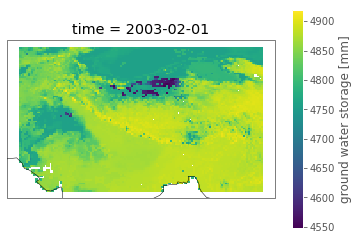

In [4]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
LIS.GWS_tavg[0].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),x='long',y='lat', add_colorbar=True)
ax.coastlines()

## read the groundwater well district shapefile

In [5]:
fp="../../files/Groundwater/dugwells_districts_d.shp"

In [6]:
shdf = gpd.read_file(fp)

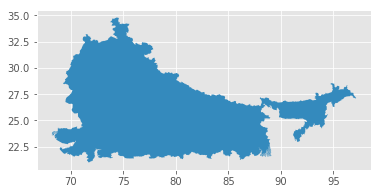

In [7]:
shdf.plot()

### Download the GRACE data from S3 bucket

- [Dataset Source](https://neptune.gsfc.nasa.gov/gngphys/index.php?section=413)
- [Dataset Documentation](https://neptune.gsfc.nasa.gov/uploads/images_db/GSFC_mascons_HDF5_format_v02_3.pdf)

In [8]:
fileName = '../../files/GRACE/GSFC.glb.200301_201607_v02.4-ICE6G.h5'
grace_file = os.path.abspath(fileName)
f = extract_grace(grace_file, printGroups=False)

Data extracted: 


In [9]:
mascon = f['mascon']
soln = f['solution']
time = f['time']

mascon_gdf = get_mascon_gdf(mascon)
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


### Clip the GRACE mascons to the domain of the LIS data

In [10]:
mascon_gdf_masked = select_mascons(LIS, mascon_gdf)

## Calculate monthly average of the LIS groundwater data

In [11]:
LIS_monthly = LIS.GWS_tavg.groupby('time.month').mean()
ean

### LIS gws anomaly  - not sure this is needed?

In [ ]:
LGWS_mean = LISr.groupby('time.month').mean('time')
LISa = LISr.groupby('time.month') - LGWS_m

### The main processing step that calculates a mean value across each mascon

In [13]:
agg_data = aggregate_mascons(LIS, mascon_gdf_masked)

### Convert LIS array to Pandas dataframe for plotting

In [14]:
A3 = agg_data['data']

names = ['products', 'mascons', 'time']
index = pd.MultiIndex.from_product([agg_data[n] for n in names], names=names)
df4 = pd.DataFrame({'A3': A3.flatten()}, index=index)['A3']
df4 = df4.unstack(level='products').swaplevel().sort_index()
df4.columns = agg_data['products']
df4.index.names = ['date','mascon']

### Drop the NA values in the new GWSA mascons dataframe

In [ ]:
dfok4=df4.dropna(how='any')

In [ ]:
#print(dfok4)

### Convert GRACE time series to Pandas dataframe

In [ ]:
t = pd.DataFrame(data = {
    'time': f['time']["ref_days_middle"][0,:]
})

grc_lst = []
for m in agg_data['mascons']:
    df = pd.DataFrame(data={
        'cmwe': soln['cmwe'][m][:],
        'mascon': m
    })
    df.index = t['time'].apply(lambda x: datetime(2001,12,31) + timedelta(days=x))
    grc_lst.append(df)
    
gracedf = pd.concat(grc_lst)

In [ ]:
print(gracedf)

## Calculate mean LIS values by time

In [ ]:
grct = gracedf.groupby('time').mean()
lisst = dfok4.groupby('date').mean()

In [ ]:
gok=grct - grct.iloc[0].cmwe
gok1 = grct.reset_index()
gok1['time']=pd.to_datetime(gok1['time']).dt.floor('d')

In [ ]:
A=lisst - lisst.iloc[0].GWS_tavg 
#A.to_csv('wbm_data.csv')
Aok = lisst.reset_index()
#print(Aok)
Aok['date']=pd.to_datetime(Aok['date'])

In [ ]:
#Aok['GWS_tavg']=Aok['GWS_tavg']*10

### Plot GWSA trend from LIS time series

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
gok1.plot(ax=ax, y='cmwe', x='time',linewidth = 2,color='brown')
Aok.plot(ax=ax,y='GWS_tavg', x='date', linewidth = 2,color='blue') #x='date'
plt.ylabel('ground water storage anomaly(cm)', fontsize = 14)
plt.xlabel('year', fontsize = 14) #'year'
plt.xticks(rotation=0)
ax.legend(['GRACE','LIS'],fontsize = 14, loc = 1)
font = {'family' : 'Times',
        'size'   : 14}
matplotlib.rc('font', **font)

In [ ]:
GRACE_mass = gok1.cmwe.values
GRACE_decyear = f['time']['yyyy_doy_yrplot_middle'][2, :]
LIS = Aok.GWS_tavg.values
LIS_dy1 = pd.Series(Aok.date).apply(lambda x: pyasl.decimalYear(x))

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(GRACE_decyear,signal.detrend(GRACE_mass, type = 'linear'),color='brown',linewidth = 2)
plt.plot(LIS_dy1,signal.detrend(LIS, type = 'linear'),color='blue',linewidth = 2)

plt.ylabel('ground water storage anomaly (cm)', fontsize = 14)
plt.xlabel('year', fontsize = 14)
plt.legend(['GRACE','LIS'],fontsize = 14, loc = 1)

font = {'family' : 'Times',
        'size'   : 14}

matplotlib.rc('font', **font)

In [ ]:
t_grace=get_cmwe_trend_analysis(masked_gdf4, f)

In [ ]:
masked_gdf4.plot(column='avg_mass_change_cm',cmap='viridis', legend=True)

In [ ]:
t_grace_cl =gpd.overlay(shdf,t_grace, how='intersection')

In [ ]:
#print(t_grace_cl)

In [ ]:
plt.figure(figsize=(12,8))
t_grace_cl.plot(column='avg_mass_change_cm',cmap='viridis', legend=True)
plt.ylabel('latitude', fontsize = 12)
plt.xlabel('longtitude', fontsize = 12)

### Calculate LIS GWSA trend

#### Convert the date from multiindex into date column

In [ ]:
LISga = dfok4.reset_index()

In [ ]:
#print(LISga)

### Calculate LIS GWSA trend per mascon

In [ ]:
LIS_t=pd.DataFrame()
LIS_t['trend']=LISga.groupby('mascon').apply(lambda x: trend_analysis(x['date'].apply(lambda x: pyasl.decimalYear(x)), 
                                                   x['GWS_tavg'], optimization = True)[1] )

In [ ]:
#LIS_t['trend']=LIS_t['trend']*10

### Join the GWSA trend with mascon dataframe (get geometry)

In [ ]:
mascon_t_g=t_grace_cl.join(LIS_t, on='mascon')

### Plot the spatial trend of each mascon for UGWA data

In [ ]:
# WBM trend for indus basin
mascon_t_g.plot(column='trend',cmap='viridis', legend=True) 

In [ ]:
mascon_t_g.plot(column='trend',cmap='viridis',vmin=-0.5,vmax=1, legend=True) 